__Problem with ViperGPT / AmadaeusGPT__: We all felt that the model had to be given explicit instructions on how to use the API. Reason for this might be that ViperGPT / AmadaeusGPT use single-shot promting to generate each code block. But, single shot prompting doesn't fully exploit the executable DSL, the dataset, and potential domain knowledge. 

__Potential Pipeline__:
- Tree of thought algorithm: https://arxiv.org/abs/2305.10601
- Ziniu's paper: https://arxiv.org/abs/2306.08129

For each timestep, find out how to:
1. Propose what actions we can currently do [Write code to caption image / write code to calculate distance / etc.]
2. Rank the actions based on what is promising.
3. (A* search) Execute the top action(s)
4. Self critique: Was the last action meaningful? If not, backtrack.

Why is this interesting:
- Each of these steps is done by prompting LLM / by symbolic programs / by neurosymbolic programs [eg: NEAR partial programs]
- Proposal, ranking, and self-critiquing can be doped with domain-specific knowledge base.


__When does the rocket lift off?__

Answer = 45 seconds in

In [2]:
from main_simple_lib import *


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/asehgal/envs/envs/vipergpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA SETUP: CUDA runtime path found: /home/asehgal/envs/envs/vipergpt/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /home/asehgal/envs/envs/vipergpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


/home/asehgal/envs/envs/vipergpt/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/asehgal/envs/envs/vipergpt/lib/libcudart.so.11.0'), PosixPath('/home/asehgal/envs/envs/vipergpt/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)
2023-07-28 13:58:05.305903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, 

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Using cache found in /home/asehgal/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/asehgal/.cache/torch/hub/intel-isl_MiDaS_master


VISION BACKBONE USE GRADIENT CHECKPOINTING:  False
LANGUAGE BACKBONE USE GRADIENT CHECKPOINTING:  False
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B


In [3]:
%%HTML
<video width="320" height="240" controls>
  <source src="data/videos/crs28small.mp4" type="video/mp4">
</video>

In [4]:
import pandas as pd
df = pd.read_csv("results/results_11.csv")
df

,result,answer,code,id,query,img_path,possible_answers
0,The rocket lifts off at time 23 seconds.,NaN,"def execute_command_0(video, possible_answers,...",0,What time in the video does the rocket lift off?,data/videos/crs28small.mp4,NaN


In [5]:
# Even right now the model is not using the API to its full extent.
# frame.simple_query("Is the rocket lifting off?") is ALWAYS true technically.
# A better promt would be to ask:
# - frame.simple_query("Is the rocket in the air?")
print(df['code'][0])

def execute_command_0(video, possible_answers, query, ImagePatch, VideoSegment, llm_query, bool_to_yesno, distance,
best_image_match):
    # Answer is:def execute_command(video):
    video_segment = VideoSegment(video)
    for i, frame in enumerate(video_segment.frame_iterator()):
        if frame.exists("rocket") and frame.simple_query("Is the rocket lifting off?") == "yes":
            return f"The rocket lifts off at time {i} seconds."

In [6]:
import decord
from decord import cpu, gpu
import numpy as np

def my_get_video(video_path):
    # CTRL C/V from internal code
    video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
    decord.bridge.set_bridge('torch')
    vlen = len(video_reader)
    original_fps = video_reader.get_avg_fps()
    num_frames = int(vlen * 30 / original_fps)
    num_frames = min(30, num_frames)
    frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(int)
    video = video_reader.get_batch(frame_idxs).byte()
    video = video.permute(0, 3, 1, 2)
    return video

video = my_get_video("data/videos/crs28small.mp4")


In [7]:
video.shape

torch.Size([30, 3, 512, 512])

In [8]:
video_segment = VideoSegment(video)
frame_infos = []
for i, frame in enumerate(video_segment.frame_iterator()):
    frame_info = (i, frame.exists("rocket"), frame.simple_query("Is the rocket lifting off?"))
    frame_infos.append(frame_info)
frame_infos

[(0, True, 'no'),
 (1, True, 'no'),
 (2, True, 'no'),
 (3, True, 'no'),
 (4, True, 'no'),
 (5, True, 'no'),
 (6, True, 'no'),
 (7, True, 'no'),
 (8, True, 'no'),
 (9, True, 'no'),
 (10, True, 'no'),
 (11, True, 'no'),
 (12, True, 'no'),
 (13, True, 'no'),
 (14, True, 'no'),
 (15, True, 'no'),
 (16, True, 'no'),
 (17, True, 'no'),
 (18, True, 'no'),
 (19, True, 'no'),
 (20, True, 'no'),
 (21, True, 'no'),
 (22, True, 'no'),
 (23, True, 'yes'),
 (24, True, 'yes'),
 (25, True, 'yes'),
 (26, True, 'yes'),
 (27, True, 'yes'),
 (28, True, 'yes'),
 (29, True, 'yes')]

23

Text(0.5, 1.0, "(24, True, 'yes')")

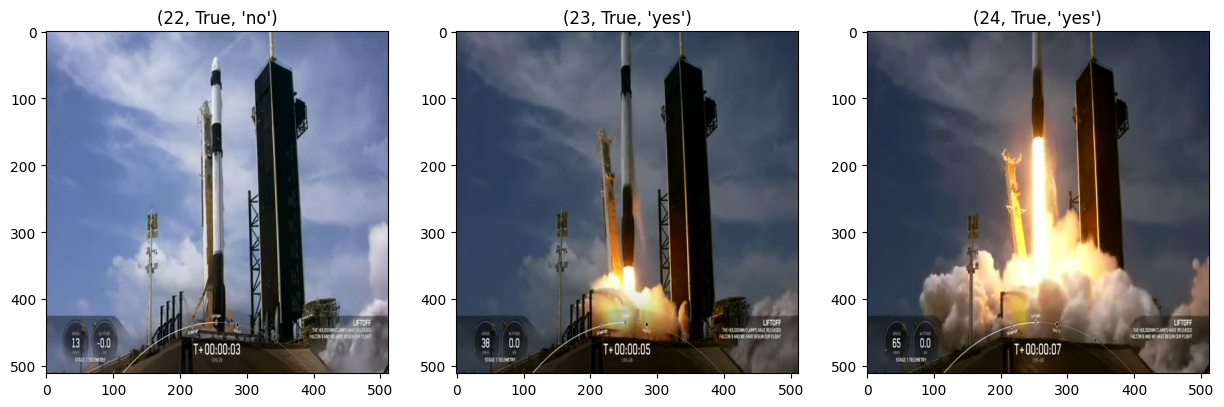

In [9]:
import matplotlib.pyplot as plt
liftoff_frame = sorted([i for i, rocket, is_liftoff in frame_infos if rocket and (is_liftoff == 'yes')])[0]
print(liftoff_frame)
# plot the frame before, the liftoff frame, and the frame after
fig, ax = plt.subplots(1,3, figsize=(15,5))

assert 0 < liftoff_frame < len(video) - 1, 'liftoff frame should be in the middle of the video'

ax[0].imshow(video[liftoff_frame - 1].permute(1,2,0))
ax[1].imshow(video[liftoff_frame].permute(1,2,0))
ax[2].imshow(video[liftoff_frame + 1].permute(1,2,0))

ax[0].set_title(frame_infos[liftoff_frame - 1])
ax[1].set_title(frame_infos[liftoff_frame])
ax[2].set_title(frame_infos[liftoff_frame + 1])
